# Dataset Loading (CASIA-FASD Dataset (Kaggle))

## Face Cropped CASIA-FASD Dataset

In [1]:
!pip install datasets --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [2]:
from datasets import load_dataset

Dataset = load_dataset("Bahareh0281/CASIA-FASD-Cropped")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1655 [00:00<?, ? examples/s]

In [ ]:
Dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1655
    })
})

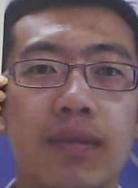

In [ ]:
Dataset['train']['image'][0]

In [ ]:
Dataset['train']['label'][0] # 0: fake; 1: real

0

In [3]:
images = Dataset['train']['image']
labels = Dataset['train']['label']

# Feature Extraction

In [4]:
import cv2
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from numpy.fft import fft2, fftshift
import numpy as np

In [5]:
def extract_fft_features(image):
    """
    Extract frequency domain features using FFT.
    """
    gray_image = rgb2gray(np.asarray(image))
    f = fft2(gray_image)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

In [6]:
def extract_lbp_features(image, P=8, R=1):
    """
    Extract texture features using Local Binary Patterns (LBP).
    """
    gray_image = rgb2gray(np.asarray(image))
    lbp = local_binary_pattern(gray_image, P, R, method="uniform")
    return lbp

In [7]:
def display_image(image, title="Image"):
    """
    Display an image using matplotlib.
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [8]:
# Process each cropped face image to extract features
fft_features = []
lbp_features = []

for image in images:
    # Extract and store FFT features
    fft_feature = extract_fft_features(image)
    fft_features.append(fft_feature)

    # Extract and store LBP features
    lbp_feature = extract_lbp_features(image)
    lbp_features.append(lbp_feature)

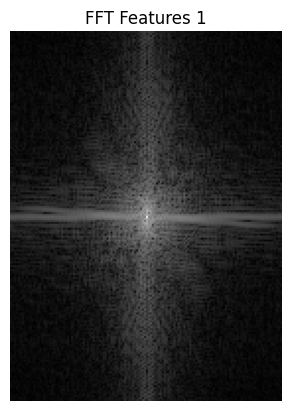

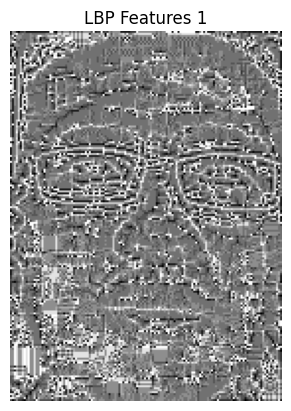

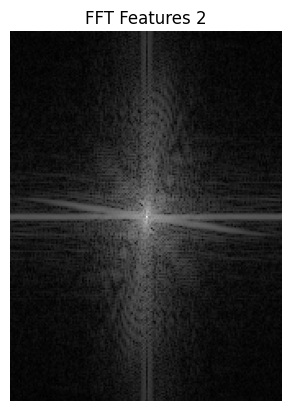

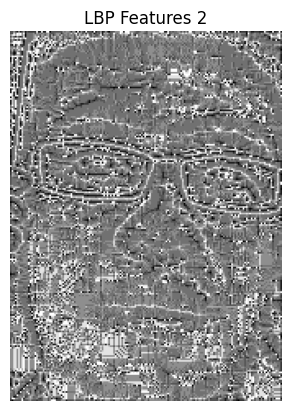

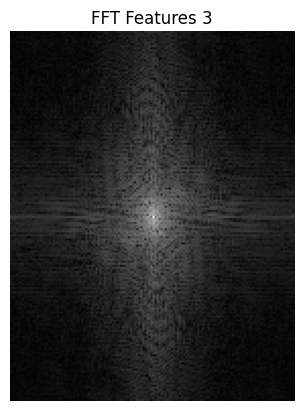

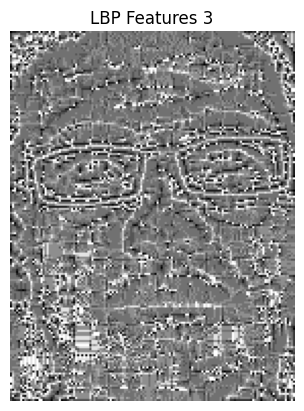

In [ ]:
import matplotlib.pyplot as plt
# Display a few FFT and LBP features
for i in range(3):
    display_image(fft_features[i], title=f"FFT Features {i+1}")
    display_image(lbp_features[i], title=f"LBP Features {i+1}")

## Depth Information (Simplified Approach)

In [9]:
def extract_depth_features(lbp_feature):
    """
    Simplified depth feature extraction using the variance of LBP features.
    """
    depth_feature = np.var(lbp_feature)
    return depth_feature

In [10]:
# Extract simplified depth features
depth_features = []

for lbp_feature in lbp_features:
    depth_feature = extract_depth_features(lbp_feature)
    depth_features.append(depth_feature)

In [ ]:
# Display a few depth features
print("Depth Features (variance of LBP features):")
for i in range(3):
    print(f"Depth Feature {i+1}: {depth_features[i]}")

Depth Features (variance of LBP features):
Depth Feature 1: 3.887925167982007
Depth Feature 2: 3.5881089526761936
Depth Feature 3: 3.6227360333095926


In [35]:
# Resizing fucntion
def resize_features(features, target_shape):
    resized_features = []
    for feature in features:
        resized_feature = cv2.resize(feature, target_shape)
        resized_features.append(resized_feature)
    return np.array(resized_features)


# Deep Learning Method

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## CNN

In [37]:
import cv2

# Define the target shape for resizing
target_shape = (64, 64)

# Resize FFT and LBP features
fft_features_resized = resize_features(fft_features, target_shape)
lbp_features_resized = resize_features(lbp_features, target_shape)

# Combine features along the last axis
combined_features = np.stack((fft_features_resized, lbp_features_resized), axis=-1)


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert depth features to a numpy array
depth_features = np.array(depth_features)

# Combine all features (FFT, LBP, Depth) into a single feature tensor
# Adding depth features as an additional channel
depth_features_expanded = np.repeat(depth_features[:, np.newaxis, np.newaxis], target_shape[0], axis=1)
depth_features_expanded = np.repeat(depth_features_expanded, target_shape[1], axis=2)
depth_features_expanded = depth_features_expanded[..., np.newaxis]

# Concatenate FFT, LBP, and depth features
combined_features = np.concatenate([combined_features, depth_features_expanded], axis=-1)

# Convert labels to numpy array
labels = np.array(Dataset['train']['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_shape[0], target_shape[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
34/34 [==============================] - 2s 19ms/step - loss: 1.1271 - accuracy: 0.7063 - val_loss: 0.6322 - val_accuracy: 0.7170
Epoch 2/20
34/34 [==============================] - 0s 11ms/step - loss: 0.5678 - accuracy: 0.7507 - val_loss: 0.5627 - val_accuracy: 0.7170
Epoch 3/20
34/34 [==============================] - 0s 9ms/step - loss: 0.5594 - accuracy: 0.7526 - val_loss: 0.5826 - val_accuracy: 0.7170
Epoch 4/20
34/34 [==============================] - 0s 9ms/step - loss: 0.5477 - accuracy: 0.7526 - val_loss: 0.5453 - val_accuracy: 0.7170
Epoch 5/20
34/34 [==============================] - 0s 8ms/step - loss: 0.5398 - accuracy: 0.7554 - val_loss: 0.5515 - val_accuracy: 0.7170
Epoch 6/20
34/34 [==============================] - 0s 8ms/step - loss: 0.5335 - accuracy: 0.7526 - val_loss: 0.5427 - val_accuracy: 0.7170
Epoch 7/20
34/34 [==============================] - 0s 7ms/step - loss: 0.5220 - accuracy: 0.7526 - val_loss: 0.5416 - val_accuracy: 0.7170
Epoch 8/20
34/34 [

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


11/11 [==============================] - 0s 4ms/step - loss: 0.4307 - accuracy: 0.8006
Test Accuracy: 80.06%


## InceptionV3

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [66]:
# Resize images to meet the minimum size requirement of InceptionV3 (75x75 pixels)
target_size = (75, 75)
resized_images = np.array([array_to_img(img, scale=False).resize(target_size) for img in combined_features_resized])

# Convert resized images back to array
combined_features_resized = np.array([img_to_array(img) for img in resized_images])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resized, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [67]:
# Load the pre-trained model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))  # Exclude the top layer

# Freeze the layers of the pre-trained model
for layer in inception_model.layers:
    layer.trainable = False

# Add a global spatial average pooling layer
x = inception_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with the number of classes you have (binary classification)
predictions = Dense(2, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=inception_model.input, outputs=predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [68]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
42/42 [==============================] - 13s 112ms/step - loss: 0.9497 - accuracy: 0.7236 - val_loss: 0.4760 - val_accuracy: 0.7915
Epoch 2/10
42/42 [==============================] - 1s 26ms/step - loss: 0.4695 - accuracy: 0.7749 - val_loss: 0.4516 - val_accuracy: 0.7915
Epoch 3/10
42/42 [==============================] - 1s 23ms/step - loss: 0.4447 - accuracy: 0.7998 - val_loss: 0.4965 - val_accuracy: 0.7613
Epoch 4/10
42/42 [==============================] - 1s 23ms/step - loss: 0.4171 - accuracy: 0.8044 - val_loss: 0.4510 - val_accuracy: 0.7825
Epoch 5/10
42/42 [==============================] - 1s 23ms/step - loss: 0.3794 - accuracy: 0.8187 - val_loss: 0.4903 - val_accuracy: 0.7946
Epoch 6/10
42/42 [==============================] - 1s 23ms/step - loss: 0.3975 - accuracy: 0.8187 - val_loss: 0.5238 - val_accuracy: 0.7341
Epoch 7/10
42/42 [==============================] - 1s 19ms/step - loss: 0.3550 - accuracy: 0.8331 - val_loss: 0.4631 - val_accuracy: 0.7674
Epoch 8/10


In [69]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

11/11 [==============================] - 0s 26ms/step - loss: 0.5005 - accuracy: 0.7795
Test Loss: 0.5005434155464172, Test Accuracy: 0.7794561982154846


## ResNet50

In [70]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [71]:
import cv2

# Assuming combined_features_resized has images of shape (64, 64, 3)
# Resize images to (224, 224, 3)
combined_features_resized = np.array([cv2.resize(img, (224, 224)) for img in combined_features_resized])

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resized, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [73]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Adjust to match your number of classes

94765736/94765736 [==============================] - 0s 0us/step


In [74]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [75]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
42/42 [==============================] - 15s 221ms/step - loss: 0.7539 - accuracy: 0.6518 - val_loss: 0.4885 - val_accuracy: 0.7976
Epoch 2/10
42/42 [==============================] - 5s 123ms/step - loss: 0.5474 - accuracy: 0.7470 - val_loss: 0.4793 - val_accuracy: 0.7976
Epoch 3/10
42/42 [==============================] - 5s 123ms/step - loss: 0.5431 - accuracy: 0.7394 - val_loss: 0.4687 - val_accuracy: 0.8006
Epoch 4/10
42/42 [==============================] - 5s 131ms/step - loss: 0.5142 - accuracy: 0.7545 - val_loss: 0.4885 - val_accuracy: 0.8036
Epoch 5/10
42/42 [==============================] - 5s 122ms/step - loss: 0.5253 - accuracy: 0.7613 - val_loss: 0.5242 - val_accuracy: 0.7976
Epoch 6/10
42/42 [==============================] - 5s 124ms/step - loss: 0.5074 - accuracy: 0.7795 - val_loss: 0.4687 - val_accuracy: 0.8006
Epoch 7/10
42/42 [==============================] - 5s 121ms/step - loss: 0.4771 - accuracy: 0.7719 - val_loss: 0.4482 - val_accuracy: 0.8097
Epoch

In [76]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

11/11 [==============================] - 1s 95ms/step - loss: 0.4943 - accuracy: 0.7976
Test Loss: 0.49426066875457764, Test Accuracy: 0.7975831031799316


In [79]:
# Save the model
model.save('anti_spoofing_model_resnet.h5')

## apple/mobilevit-small

In [ ]:
print(f"Number of samples in combined_features: {len(combined_features)}")
print(f"Number of samples in labels: {len(labels)}")


Number of samples in combined_features: 1655
Number of samples in labels: 16


In [ ]:
from transformers import MobileViTFeatureExtractor, MobileViTModel, MobileViTConfig
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:

# Convert depth features to a numpy array
depth_features = np.array(depth_features)

# Combine all features (FFT, LBP, Depth) into a single feature tensor
# Adding depth features as an additional channel
depth_features_expanded = np.repeat(depth_features[:, np.newaxis, np.newaxis], target_shape[0], axis=1)
depth_features_expanded = np.repeat(depth_features_expanded, target_shape[1], axis=2)
depth_features_expanded = depth_features_expanded[..., np.newaxis]

# Concatenate FFT, LBP, and depth features
combined_features = np.concatenate([combined_features, depth_features_expanded], axis=-1)

# Convert labels to numpy array
labels = np.array(Dataset['train']['label'])

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# Normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Convert data to PyTorch tensors and permute dimensions to match (batch_size, channels, height, width)
X_train_pt = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_pt = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_pt = torch.tensor(y_train, dtype=torch.long)
y_test_pt = torch.tensor(y_test, dtype=torch.long)

In [ ]:

# Load the feature extractor and model configuration
feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/mobilevit-small")
config = MobileViTConfig.from_pretrained("apple/mobilevit-small")

# Load the pretrained MobileViT model
model = MobileViTModel.from_pretrained("apple/mobilevit-small", config=config)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Identify and modify the correct input layer to accept 5-channel input
class CustomMobileViTModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomMobileViTModel, self).__init__()
        self.base_model = base_model

        # Modify the first convolutional layer to accept 5 channels instead of 3
        self.base_model.embeddings.conv = nn.Conv2d(
            in_channels=5,  # 3 RGB channels + 2 additional channels (depth)
            out_channels=self.base_model.embeddings.conv.out_channels,
            kernel_size=self.base_model.embeddings.conv.kernel_size,
            stride=self.base_model.embeddings.conv.stride,
            padding=self.base_model.embeddings.conv.padding
        )

        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model(pixel_values=pixel_values)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        return logits

# Instantiate the custom model
custom_model = CustomMobileViTModel(model, num_classes=2)

# Freeze the layers of the pretrained model except the new convolutional layer and classifier
for name, param in custom_model.named_parameters():
    if 'base_model.embeddings.conv' not in name and 'classifier' not in name:
        param.requires_grad = False

# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model.to(device)



AttributeError: 'MobileViTModel' object has no attribute 'embeddings'

In [ ]:
# Training parameters
batch_size = 16
epochs = 10
learning_rate = 1e-4

# Data loaders
train_data = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
test_data = torch.utils.data.TensorDataset(X_test_pt, y_test_pt)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=learning_rate)


In [ ]:
# Training loop
custom_model.train()
for epoch in range(epochs):
    total_loss = 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = custom_model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[16, 5, 64, 64] to have 3 channels, but got 5 channels instead

In [ ]:
# Evaluation
with torch.no_grad():
    outputs_test = model(**inputs_test)
    predicted_labels = torch.argmax(outputs_test.logits, dim=1)
    accuracy = (predicted_labels == torch.argmax(torch.tensor(y_test), dim=1)).sum().item() / len(y_test)
    print(f"Accuracy: {accuracy}")

In [ ]:
# Optionally save the model
torch.save(model.state_dict(), 'mobilevit_model.pth')

## google/vit-base-patch16-224

In [ ]:
# from transformers import ViTImageProcessor, ViTForImageClassification
# from PIL import Image
# import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

# processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model p

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

In [49]:
# Assuming combined_features_resized has images of shape (224, 224, 3)
target_size = (224, 224)
resized_images = np.array([cv2.resize(img, target_size) for img in combined_features_resized])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(resized_images, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [28]:
# Step 1: Load pretrained model and processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head
model.classifier = nn.Linear(model.config.hidden_size, 2)
nn.init.xavier_uniform_(model.classifier.weight)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [30]:
# Step 2: Convert data to PyTorch tensors and permute dimensions
# Normalize the image data
X_train_pt = torch.tensor(X_train / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_pt = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

In [31]:
# Step 3: Define optimizer and criterion for the classifier head
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5)  # Only optimize classifier parameters
criterion = nn.CrossEntropyLoss()

In [32]:
# Step 4: Training loop
model.train()
epochs = 15
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, torch.argmax(batch_labels, dim=1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")


Epoch 1/15, Loss: 36.11052280664444
Epoch 2/15, Loss: 31.701439261436462
Epoch 3/15, Loss: 28.70004779100418
Epoch 4/15, Loss: 26.775625467300415
Epoch 5/15, Loss: 25.59966889023781
Epoch 6/15, Loss: 24.906786859035492
Epoch 7/15, Loss: 24.508611023426056
Epoch 8/15, Loss: 24.282469779253006
Epoch 9/15, Loss: 24.153143346309662
Epoch 10/15, Loss: 24.07655557990074
Epoch 11/15, Loss: 24.027834802865982
Epoch 12/15, Loss: 23.99342107772827
Epoch 13/15, Loss: 23.96617019176483
Epoch 14/15, Loss: 23.942447006702423
Epoch 15/15, Loss: 23.920471847057343


In [33]:
# Step 5: Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning the entire model
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Continue training with all layers unfrozen
model.train()
epochs_finetune = 15
for epoch in range(epochs_finetune):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Fine-tuning Epoch {epoch+1}/{epochs_finetune}, Train Loss: {total_loss:.4f}")


Fine-tuning Epoch 1/20, Loss: 23.7666
Fine-tuning Epoch 2/20, Loss: 22.9948
Fine-tuning Epoch 3/20, Loss: 22.2982
Fine-tuning Epoch 4/20, Loss: 21.5759
Fine-tuning Epoch 5/20, Loss: 20.9149
Fine-tuning Epoch 6/20, Loss: 20.3757
Fine-tuning Epoch 7/20, Loss: 19.9431
Fine-tuning Epoch 8/20, Loss: 19.5692
Fine-tuning Epoch 9/20, Loss: 19.2246
Fine-tuning Epoch 10/20, Loss: 18.8888
Fine-tuning Epoch 11/20, Loss: 18.5519
Fine-tuning Epoch 12/20, Loss: 18.2140
Fine-tuning Epoch 13/20, Loss: 17.8784
Fine-tuning Epoch 14/20, Loss: 17.5474
Fine-tuning Epoch 15/20, Loss: 17.2198
Fine-tuning Epoch 16/20, Loss: 16.8924
Fine-tuning Epoch 17/20, Loss: 16.5635
Fine-tuning Epoch 18/20, Loss: 16.2298
Fine-tuning Epoch 19/20, Loss: 15.8899
Fine-tuning Epoch 20/20, Loss: 15.5444


In [41]:
# Step 7: Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test_pt[i:i+batch_size]
        batch_labels = y_test_pt[i:i+batch_size]

        outputs = model(pixel_values=batch_inputs)
        _, predicted = torch.max(outputs.logits, 1)

        total += batch_labels.size(0)
        correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

accuracy = 100 * correct / total
print(f"Final Accuracy on test set: {accuracy:.2f}%")

Final Accuracy on test set: 83.99%


In [80]:
# Save the model
model.save('anti_spoofing_model_google.h5')

# timm/mobilevit_s.cvnets_in1k

In [47]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import timm
from timm import create_model

In [50]:
# Assuming combined_features_resized has images of shape (64, 64, 3)
target_size = (224, 224)
resized_images = np.array([cv2.resize(img, target_size) for img in combined_features_resized])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(resized_images, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [51]:
# Step 1: Load pretrained model and processor
model = create_model('mobilevit_s', pretrained=True, num_classes=1000)  # Load the pretrained mobilevit_s model
num_features = model.head.in_features  # Get the number of input features for the classifier head

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head for binary classification
model.head = nn.Linear(num_features, 2)
nn.init.xavier_uniform_(model.head.weight)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

In [52]:
# Step 2: Convert data to PyTorch tensors and permute dimensions
# Normalize the image data
X_train_pt = torch.tensor(X_train / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_pt = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_pt = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_pt = torch.tensor(y_test, dtype=torch.long).to(device)


In [53]:
# Step 3: Define optimizer and criterion for the classifier head
optimizer = optim.Adam(model.head.parameters(), lr=1e-5)  # Only optimize classifier head parameters
criterion = nn.CrossEntropyLoss()

In [60]:
# Step 4: Training loop with frozen base layers
model.train()
epochs = 15
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = processor(images=X_train[i:i+batch_size], return_tensors="pt").pixel_values.to(device)
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(**inputs, labels=batch_labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")



TypeError: ByobNet.forward() got an unexpected keyword argument 'pixel_values'

In [ ]:
# Step 5: Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning the entire model
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Continue training with all layers unfrozen
for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(batch_inputs)
        loss = criterion(outputs.logits, torch.argmax(batch_labels, dim=1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Fine-tuning Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [ ]:

# Step 6: Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_inputs = X_test_pt[i:i+batch_size]
        batch_labels = y_test_pt[i:i+batch_size]

        outputs = model(batch_inputs)
        _, predicted = torch.max(outputs.logits, 1)

        total += batch_labels.size(0)
        correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")


# ResNet New Approach

In [81]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [82]:
import cv2

# Assuming combined_features_resized has images of shape (64, 64, 3)
# Resize images to (224, 224, 3)
combined_features_resized = np.array([cv2.resize(img, (224, 224)) for img in images])

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resized, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Adjust to match your number of classes

In [ ]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
# Save the model
model.save('anti_spoofing_model_resnet.h5')